In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset
import torchvision

import numpy as np

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import h5py
import glob

import pickle


In [3]:
# We're going to use the mini Imagenet dataset 
# Please run the cell below to set it up. 
# If you want to convert images to many formats/resolutions (for the demo), set DEMO_FLAG to True


In [4]:
DEMO_FLAG = True

--2021-10-06 14:23:25--  https://data.deepai.org/miniimagenet.zip
Resolving data.deepai.org (data.deepai.org)... 138.201.36.183
Connecting to data.deepai.org (data.deepai.org)|138.201.36.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1073666401 (1024M) [application/x-zip-compressed]
Saving to: ‘miniimagenet.zip.1’

miniimagenet.zip.1  100%[===================>]   1024M  26.2MB/s    in 41s     

2021-10-06 14:24:07 (25.2 MB/s) - ‘miniimagenet.zip.1’ saved [1073666401/1073666401]

Unzipping!
Archive:  miniimagenet.zip
replace mini-imagenet-cache-test.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
Displaying samples!
mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘data_sm’: File exists
mkdir: cannot create directory ‘data_png’: File exists
mkdir: cannot create directory ‘data_npy’: File exists
mkdir: cannot create directory ‘data_pt’: File exists
Saving Images in more common format


  0%|          | 0/1536 [00:00<?, ?it/s]

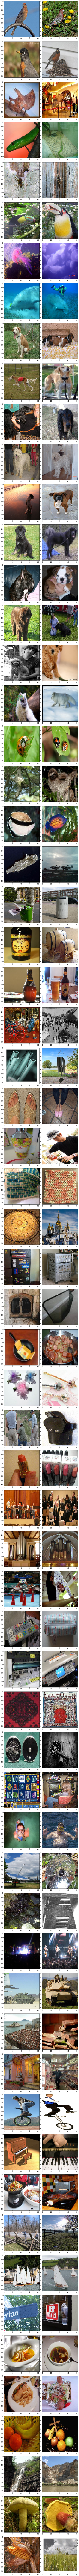

In [5]:
#@title Execute to download data :) { form-width: "50%" }
%matplotlib inline


## Download Data
print("Downloading Data")
!wget https://data.deepai.org/miniimagenet.zip


## Unzip  Data
print("Unzipping!")
!unzip miniimagenet.zip

## Extract Data
with open('mini-imagenet-cache-train.pkl', 'rb') as pickle_file:
    content = pickle.load(pickle_file)


## Optionally Display 2 samples per class
if DEMO_FLAG:
  print("Displaying samples!")
  plt.figure(figsize=(8, 4*64))
  n_classes = 64
  i = 0
  for class_id in range(n_classes):
    i+=1
    plt.subplot(n_classes, 2, i)
    plt.imshow(content['image_data'][600*class_id + 0])
    i+=1
    plt.subplot(n_classes, 2, i)
    plt.imshow(content['image_data'][600*class_id + 1])

  plt.tight_layout()
 #  plt.show()
else:
  print("Skipping displaying samples")

## Create folders
!mkdir data     # 224x224
!mkdir data_sm  # 84x84
!mkdir data_png # 224x224 (png)
!mkdir data_npy # 224x224 (numpy)
!mkdir data_pt  # 224x224 (torch)

# Let's save our data into a bit of a more common format
# We'll also upsample our images


## Save images as 224x224 in the data/ folder, optionally other folders too. 
print("Saving Images in more common format")
up = torchvision.transforms.Resize((224,224))
uid = 0
for image in tqdm(content['image_data'][::25]): # we skip a lot
  # There are 600 images per class, in order.
  image_class = uid//600 # This gives us which class the image belongs to 
  idx_in_class = uid%600 # This gives us the # that the image is in that class


  old = torch.Tensor(image).int() # convert to Tensor

  # Upsample, convert to int
  new_img = up(torch.Tensor(image).permute(2,0,1)).permute(1,2,0).int()

  # Save image as jpg 
  plt.imsave(f"data/{uid}_{image_class}_{idx_in_class}.jpg", new_img.numpy().astype(np.uint8))

  if DEMO_FLAG:
    plt.imsave(f"data_sm/{uid}_{image_class}_{idx_in_class}.jpg", old.numpy().astype(np.uint8))
    plt.imsave(f"data_png/{uid}_{image_class}_{idx_in_class}.png", new_img.numpy().astype(np.uint8))

    np.save(f"data_npy/{uid}_{image_class}_{idx_in_class}.npy", new_img.numpy().astype(np.uint8))
    torch.save(new_img, f"data_pt/{uid}_{image_class}_{idx_in_class}.pt")

  uid+=25

In [6]:
# Now we can begin our data loader!

class MiniImageNet(Dataset):
    def __init__(self, root):
      self.files = glob.glob(root + "/*")
      self.n_classes = 64

    def __len__(self):
      return len(self.files)

    def __getitem__(self, idx):

      file_name = self.files[idx] # Get the file name

      image = torchvision.io.read_image(file_name).float() # get image

      class_id = int(file_name.split('_')[-2]) # get the class ID

      class_ohe = torch.eye(self.n_classes)[class_id] # convert to OHE
      
      return image, class_ohe # X, y
      

torch.Size([3, 224, 224]) tensor(63)


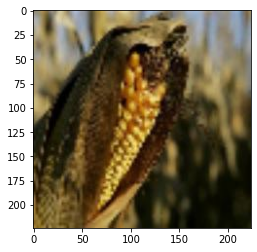

torch.Size([3, 224, 224]) tensor(63)


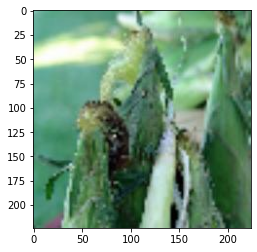

In [7]:
dataset = MiniImageNet('data/')

img, label = dataset[42]
print(img.shape, torch.argmax(label))
plt.imshow(img.permute(1,2,0)/255)
plt.show()

# Let's find another example of this class!

for img_2, label_2 in dataset:
  if torch.argmax(label) == torch.argmax(label_2) and torch.sum(img) != torch.sum(img_2):
    print(img_2.shape, torch.argmax(label_2))
    plt.imshow(img_2.permute(1,2,0)/255)
    break

In [8]:
# Now we can add a dataloader...
from torch.utils.data import DataLoader

torch.manual_seed(42)


In [9]:
%%time

dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

for batch in dataloader:
  pass

# Wall time: 590 ms

CPU times: user 17.6 s, sys: 26.8 ms, total: 17.7 s
Wall time: 553 ms


In [10]:
%%time
# Let's train a basic model as a baseline!

model = torchvision.models.resnet18()
model.fc = torch.nn.Linear(512, 64) # change head

model = model.cuda() 

crit = torch.nn.CrossEntropyLoss() 
opt = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

epochs = 4
it = 0

losses = []

for epoch in range(epochs):
  for X, y in tqdm(dataloader):

    X = X.cuda()
    y = y.float().cuda()

    opt.zero_grad()

    y_hat = model(X).cuda()
   
    loss = crit(y_hat, torch.argmax(y, dim=1))
    
    loss.backward()
    opt.step()
    
    if it%(len(dataloader)//2)==0:
      print(loss.item())
    it += 1
    losses.append(loss.item())
  print("Running Loss:", sum(losses)/len(losses))

# Wall time: 1min 8s

  0%|          | 0/1536 [00:00<?, ?it/s]

5.136835098266602
4.019935607910156
Running Loss: 4.421499160972114


  0%|          | 0/1536 [00:00<?, ?it/s]

4.097872257232666
4.09177827835083
Running Loss: 4.31091277312953


  0%|          | 0/1536 [00:00<?, ?it/s]

3.9465034008026123
4.309723377227783
Running Loss: 4.274810158673467


  0%|          | 0/1536 [00:00<?, ?it/s]

4.294764518737793
4.052927494049072
Running Loss: 4.256089849067696
CPU times: user 21min 45s, sys: 1.43 s, total: 21min 46s
Wall time: 1min 4s


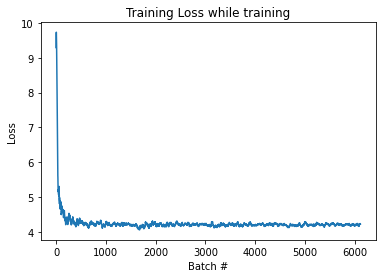

In [11]:
avg_window = 30
plt.plot(range(len(losses)-avg_window+1), [sum(losses[i:i+avg_window])/avg_window for i in range(len(losses)-avg_window+1)])
plt.title('Training Loss while training')
plt.xlabel('Batch #')
plt.ylabel('Loss')
plt.show()


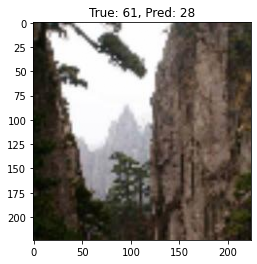

In [12]:
# View some examples
for X, y in dataloader:

    X = X.cuda()
    y = y.float().cuda()

    opt.zero_grad()

    y_hat = model(X).cuda()
    
    plt.title(f"True: {torch.argmax(y[0])}, Pred: {torch.argmax(y_hat[0])}")
    plt.imshow(X[0].detach().cpu().permute(1,2,0).numpy()/255)
    break

In [13]:
import timeit

0.8995794923976064 1
0.8002751804888248 2
0.7379754921421409 4
0.6954636787995696 8
0.6418278813362122 16
0.6479822909459472 32
0.7320238621905446 64
0.7024841737002134 128
0.7130531398579478 256
0.9554085154086351 512
0.7019827561452985 1024
0.6930221356451511 2048


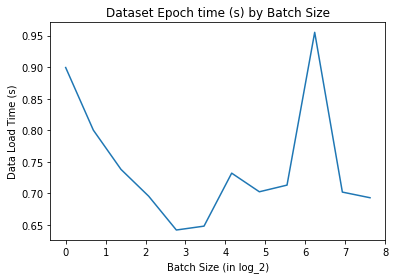

In [14]:
# Let's evaluate batch_size
x = [1,2,4,8,16,32,64,128, 256, 512, 1024, 2048]
y = []
for batch_size in x:

  start = timeit.default_timer()

  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
  for batch in dataloader:
    X,label = batch
    X = X.cuda()
    label = label.cuda()

  stop = timeit.default_timer()

  print(stop-start, batch_size)
  y.append(stop-start)


plt.title('Dataset Epoch time (s) by Batch Size')
plt.xlabel('Batch Size (in log_2)')
plt.ylabel('Data Load Time (s)')
 
plt.plot(np.log(x), y)

0.7256193878129125 0
0.6984326103702188 1
0.6977719934657216 2
0.6974907824769616 3
0.6975357159972191 4
0.6976029332727194 8
0.6975911809131503 16
0.6976260840892792 32


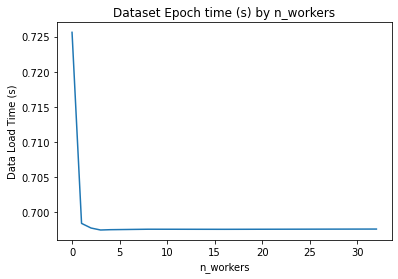

In [15]:
# Let's evaluate num_workers
x = [0,1,2,3,4, 8, 16, 32]
y = []
for n_workers in x:

  start = timeit.default_timer()

  dataloader = DataLoader(dataset, batch_size=2**3, num_workers=0, shuffle=True)
  for batch in dataloader:
    X,label = batch
    X = X.cuda()
    label = label.cuda()

  stop = timeit.default_timer()

  print(stop-start, n_workers)
  y.append(stop-start)


plt.title('Dataset Epoch time (s) by n_workers')
plt.xlabel('n_workers')
plt.ylabel('Data Load Time (s)')
 
plt.plot(x, y)

0.7656687870621681 1
0.6748771294951439 2
0.6925615333020687 3
0.699985358864069 4
0.6978188985958695 6
0.7002351507544518 8


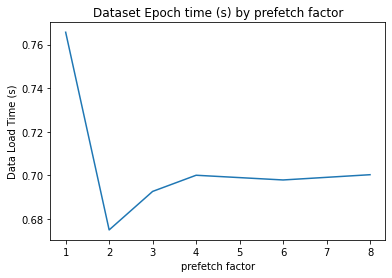

In [16]:
# Let's evaluate prefetch_factor
x = [1,2,3,4,6,8]
y = []
for prefetch in x:

  start = timeit.default_timer()

  dataloader = DataLoader(dataset, batch_size=2**3, num_workers=2, prefetch_factor=prefetch, shuffle=True)
  for batch in dataloader:
    X,label = batch
    X = X.cuda()
    label = label.cuda()
  

  stop = timeit.default_timer()

  print(stop-start, prefetch)
  y.append(stop-start)


plt.title('Dataset Epoch time (s) by prefetch factor')
plt.xlabel('prefetch factor')
plt.ylabel('Data Load Time (s)')
 
plt.plot(x, y)

6.75243610329926 0
6.786004776135087 1


<BarContainer object of 2 artists>

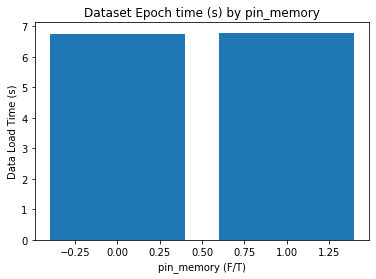

In [17]:
# Let's evaluate pin_memory
x = [0, 1]
y = []
for pin_memory in x:

  start = timeit.default_timer()

  dataloader = DataLoader(dataset, batch_size=2**5, num_workers=2, prefetch_factor=4, pin_memory=bool(pin_memory), shuffle=True)
  for samples in range(10):
    for batch in dataloader:
        X,label = batch
        X = X.cuda()
        label = label.cuda()
        X += 1
  

  stop = timeit.default_timer()

  print(stop-start, pin_memory)
  y.append(stop-start)


plt.title('Dataset Epoch time (s) by pin_memory')
plt.xlabel('pin_memory (F/T)')
plt.ylabel('Data Load Time (s)')
 
plt.bar(x, y)

In [18]:
%%time
# Let's now try with some better parameters to our dataloader.
dataloader = DataLoader(dataset, batch_size=2**5, num_workers=2, prefetch_factor=4, pin_memory=True, shuffle=True)

model = torchvision.models.resnet18()
model.fc = torch.nn.Linear(512, 64) # change head

model = model.cuda() 


crit = torch.nn.CrossEntropyLoss() 
opt = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


epochs = 4
it = 0

losses = []

for epoch in range(epochs):
  for X, y in tqdm(dataloader):

    X = X.cuda()
    y = y.float().cuda()

    opt.zero_grad()

    y_hat = model(X).cuda()
    
    
    loss = crit(y_hat, torch.argmax(y, dim=1))
    
    loss.backward()
    opt.step()
    
    if it%(len(dataloader)//2)==0:
      print(loss.item())
    it += 1
    losses.append(loss.item())
  print("Running Loss:", sum(losses)/len(losses))

# Wall time: 8.51 s

  0%|          | 0/48 [00:00<?, ?it/s]

4.235363483428955
4.352367401123047
Running Loss: 4.3309536923964815


  0%|          | 0/48 [00:00<?, ?it/s]

4.057045936584473
4.157923221588135
Running Loss: 4.208061248064041


  0%|          | 0/48 [00:00<?, ?it/s]

3.5537221431732178
3.9390602111816406
Running Loss: 4.065890530745189


  0%|          | 0/48 [00:00<?, ?it/s]

3.8637728691101074
3.5857551097869873
Running Loss: 3.9482362108925977
CPU times: user 8.21 s, sys: 1.16 s, total: 9.38 s
Wall time: 8.47 s


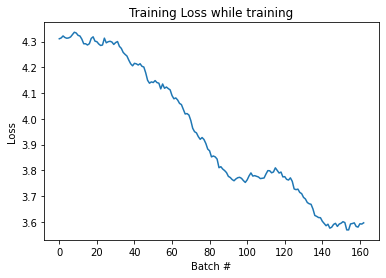

In [19]:
avg_window = 30
plt.plot(range(len(losses)-avg_window+1), [sum(losses[i:i+avg_window])/avg_window for i in range(len(losses)-avg_window+1)])
plt.title('Training Loss while training')
plt.xlabel('Batch #')
plt.ylabel('Loss')
plt.show()


In [20]:
# Let's introduce some image augmentations 

class MiniImageNetAugmentation(Dataset):
    def __init__(self, root):
      self.files = glob.glob(root + "/*")
      self.n_classes = 64
      self.augments = torchvision.transforms.Compose([
          torchvision.transforms.RandomHorizontalFlip(),
          torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
          torchvision.transforms.RandomResizedCrop((224,224)),
          torchvision.transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
          torchvision.transforms.RandomRotation(5)
      ])

    def __len__(self):
      return len(self.files)

    def __getitem__(self, idx):

      file_name = self.files[idx] # Get the file name

      image = torchvision.io.read_image(file_name).float()/255 # get image
      image = self.augments(image)

      class_id = int(file_name.split('_')[-2]) # get the class ID

      class_ohe = torch.eye(self.n_classes)[class_id] # convert to OHE
      
      return image, class_ohe # X, y
      

In [21]:
%%time
# Let's try it with augmentations now

model = torchvision.models.resnet18()
model.fc = torch.nn.Linear(512, 64) # change head

model = model.cuda() 

dataset_augment = MiniImageNetAugmentation('data/')
dataloader = DataLoader(dataset_augment, batch_size=2**5, num_workers=2, prefetch_factor=4, pin_memory=True, shuffle=True)

crit = torch.nn.CrossEntropyLoss() 
opt = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


epochs = 4
it = 0

losses = []

for epoch in range(epochs):
  for X, y in tqdm(dataloader):

    X = X.cuda()
    y = y.float().cuda()

    opt.zero_grad()

    y_hat = model(X).cuda()
    
    
    loss = crit(y_hat, torch.argmax(y, dim=1))
    
    loss.backward()
    opt.step()
    
    if it%(len(dataloader)//2)==0:
      print(loss.item())
    it += 1
    losses.append(loss.item())
  print("Running Loss:", sum(losses)/len(losses))

# Wall time: 27.8 s

  0%|          | 0/48 [00:00<?, ?it/s]

4.310884952545166
4.276179313659668
Running Loss: 4.313390890757243


  0%|          | 0/48 [00:00<?, ?it/s]

4.396491050720215
3.758166551589966
Running Loss: 4.302656980852286


  0%|          | 0/48 [00:00<?, ?it/s]

3.8242530822753906
3.92090106010437
Running Loss: 4.228625446557999


  0%|          | 0/48 [00:00<?, ?it/s]

3.812753200531006
4.125269412994385
Running Loss: 4.156202911088864
CPU times: user 8.91 s, sys: 1.13 s, total: 10 s
Wall time: 27.8 s


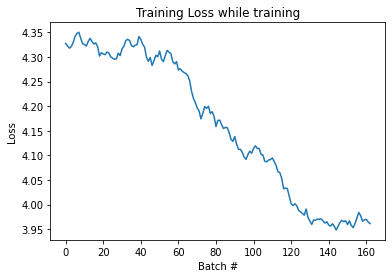

In [22]:
avg_window = 30
plt.plot(range(len(losses)-avg_window+1), [sum(losses[i:i+avg_window])/avg_window for i in range(len(losses)-avg_window+1)])
plt.title('Training Loss while training')
plt.xlabel('Batch #')
plt.ylabel('Loss')
plt.show()


In [23]:
# Let's evaluate different storage methods 
from PIL import Image


class MiniImageNetAugmentationFileOption(Dataset):
    def __init__(self, root, file_type):
      self.files = glob.glob(root + "/*")
      self.n_classes = 64
      self.augments = torchvision.transforms.Compose([
          torchvision.transforms.RandomHorizontalFlip(),
          torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
          torchvision.transforms.RandomResizedCrop((224,224)),
          torchvision.transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
          torchvision.transforms.RandomRotation(5)
      ])
      self.file_type = file_type

    def __len__(self):
      return len(self.files)

    def __getitem__(self, idx):

      file_name = self.files[idx] # Get the file name

      if self.file_type == 'jpg':
          image = torchvision.io.read_image(file_name).float() 
          
      elif self.file_type == 'png':
        image = np.asarray(Image.open(file_name).convert("RGB"))
        image.flags.writeable=True
      
      elif self.file_type == 'npy':
        image = np.load(file_name).astype(np.float32)
      
      elif self.file_type == 'pt':
        image = torch.load(file_name).float()

      else:
        image = torchvision.io.read_image(file_name).float() 

      # torch tensors are just wrappers for numpy, so this should be fast
      
      if not torch.is_tensor(image):
        image = torch.tensor(image, dtype=torch.float32)/255
      else:
        image /= 255

      if image.shape[-1] == 3:
        image = image.permute(2,0,1)

      image = self.augments(image)

      class_id = int(file_name.split('_')[-2]) # get the class ID

      class_ohe = torch.eye(self.n_classes)[class_id] # convert to OHE
      
      return image, class_ohe # X, y

  

In [24]:
# Pretend that you don't see the one million processes crashing as the data loader's workers die between 'epochs'

n_samples = 5

times = []

tmp = []
dataset = MiniImageNetAugmentationFileOption('data/', 'jpg')
dataloader = DataLoader(dataset, batch_size=2**3, num_workers=2, prefetch_factor=4, pin_memory=True, shuffle=True)
for samples in tqdm(range(n_samples)):
  start = timeit.default_timer()
  for i in dataloader:
    pass
  stop = timeit.default_timer()
  tmp.append(stop-start)
times.append(tmp)

tmp = []
dataset = MiniImageNetAugmentationFileOption('data_npy/', 'npy')
dataloader = DataLoader(dataset, batch_size=2**3, num_workers=2, prefetch_factor=4, pin_memory=True, shuffle=True)
for samples in tqdm(range(n_samples)):
  start = timeit.default_timer()
  for i in dataloader:
    pass
  stop = timeit.default_timer()
  tmp.append(stop-start)
times.append(tmp)

tmp = []
dataset = MiniImageNetAugmentationFileOption('data_pt/', 'pt')
dataloader = DataLoader(dataset, batch_size=2**3, num_workers=2, prefetch_factor=4, pin_memory=True, shuffle=True)
for samples in tqdm(range(n_samples)):
  start = timeit.default_timer()
  for i in dataloader:
    pass
  stop = timeit.default_timer()
  tmp.append(stop-start)
times.append(tmp)

tmp = []
dataset = MiniImageNetAugmentationFileOption('data_png/', 'png')
dataloader = DataLoader(dataset, batch_size=2**3, num_workers=2, prefetch_factor=4, pin_memory=True, shuffle=True)
for samples in tqdm(range(n_samples)):
  start = timeit.default_timer()
  for i in dataloader:
    pass
  stop = timeit.default_timer()
  tmp.append(stop-start)
times.append(tmp)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

<ipython-input-23-644905086b7c>:43: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  image = torch.tensor(image, dtype=torch.float32)/255
<ipython-input-23-644905086b7c>:43: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/t

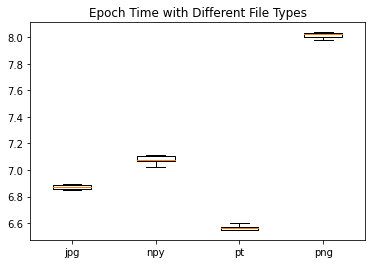

In [25]:
data = [np.array(x) for x in times]

fig7, ax7 = plt.subplots()
ax7.set_title('Epoch Time with Different File Types')
ax7.boxplot(data)

labels = ['jpg', 'npy', 'pt', 'png']
ax7.set_xticklabels(labels)

plt.show()

In [26]:
# Drastically different file sizes
!du -sh data*

15M	data
223M	data_npy
114M	data_png
889M	data_pt
6.3M	data_sm


In [27]:
# Let's evaluate different storage methods 

class MiniImageNetAugmentationPreload(Dataset):
    def __init__(self, root):
      self.files = glob.glob(root + "/*")

      self.data = [(torch.load(x).float().permute(2,0,1), self.str_to_ohe(x)) for x in self.files]
     
      self.n_classes = 64
      self.augments = torchvision.transforms.Compose([
          torchvision.transforms.RandomHorizontalFlip(),
          torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
          torchvision.transforms.RandomResizedCrop((224,224)),
          torchvision.transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
          torchvision.transforms.RandomRotation(5)
      ])

    def __len__(self):
      return len(self.files)

    def str_to_ohe(self, fname):

      class_id = int(fname.split('_')[-2]) # get the class ID

      class_ohe = torch.eye(64)[class_id] # convert to OHE

      return class_ohe

    def __getitem__(self, idx):
      
      image, label = self.data[idx]
      image = self.augments(image)
      
      return image, label # X, y



In [28]:
tmp = []
%time dataset = MiniImageNetAugmentationPreload('data_pt/')
dataloader = DataLoader(dataset, batch_size=2**5, num_workers=2, prefetch_factor=4, shuffle=True)
for samples in tqdm(range(n_samples)):
  start = timeit.default_timer()
  for i in dataloader:
    pass
  stop = timeit.default_timer()
  tmp.append(stop-start)
times.append(np.array(tmp))

CPU times: user 15.5 s, sys: 663 ms, total: 16.1 s
Wall time: 509 ms


  0%|          | 0/5 [00:00<?, ?it/s]

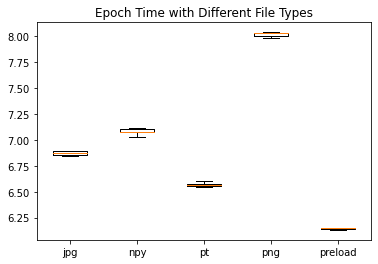

In [29]:
data = [np.array(x) for x in times]

fig7, ax7 = plt.subplots()
ax7.set_title('Epoch Time with Different File Types')
ax7.boxplot(data)
labels = ['jpg', 'npy', 'pt', 'png', 'preload']
ax7.set_xticklabels(labels)
plt.show()

In [76]:
%%time

# Let's try with the preload!

model = torchvision.models.resnet18()
model.fc = torch.nn.Linear(512, 64) # change head

model = model.cuda() 

dataset_augment = MiniImageNetAugmentationPreload('data_pt/')
dataloader = DataLoader(dataset_augment, batch_size=2**5, num_workers=2, prefetch_factor=4, pin_memory=True, shuffle=True)

crit = torch.nn.CrossEntropyLoss() 
opt = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


epochs = 4
it = 0

losses = []

for epoch in range(epochs):
  for X, y in tqdm(dataloader):

    X = X.cuda()
    y = y.float().cuda()

    opt.zero_grad()

    y_hat = model(X).cuda()
    
    
    loss = crit(y_hat, torch.argmax(y, dim=1))
    
    loss.backward()
    opt.step()
    
    if it%(len(dataloader)//2)==0:
      print(loss.item())
    it += 1
    losses.append(loss.item())
  print("Running Loss:", sum(losses)/len(losses))

# Wall time: 51.5 s

  0%|          | 0/48 [00:00<?, ?it/s]

4.2747416496276855
4.465615749359131
Running Loss: 4.4255266189575195


  0%|          | 0/48 [00:00<?, ?it/s]

4.300610542297363
4.197403430938721
Running Loss: 4.377188518643379


  0%|          | 0/48 [00:00<?, ?it/s]

4.155285358428955
4.357226371765137
Running Loss: 4.335978706677754


  0%|          | 0/48 [00:00<?, ?it/s]

4.189801216125488
4.1900787353515625
Running Loss: 4.306886970996857
CPU times: user 22.8 s, sys: 2.02 s, total: 24.8 s
Wall time: 26 s


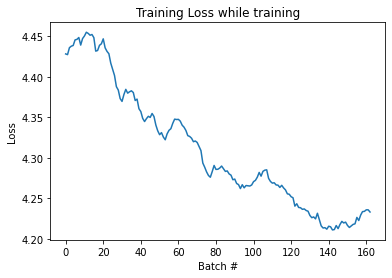

In [42]:
avg_window = 30
plt.plot(range(len(losses)-avg_window+1), [sum(losses[i:i+avg_window])/avg_window for i in range(len(losses)-avg_window+1)])
plt.title('Training Loss while training')
plt.xlabel('Batch #')
plt.ylabel('Loss')
plt.show()


In [43]:
!wget http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy
data = np.load('mnist_test_seq.npy')

In [44]:
data.shape # 20 frames per example, 10k examples

(20, 10000, 64, 64)

In [45]:
# Based on 
class MovingMNIST(Dataset):

    def __init__(self, split, train, clip_size):
        data = torch.tensor(np.load('mnist_test_seq.npy')).permute(1,0,2,3)
        # samples, t, h, w
        
        # You can train/test split in the Dataset or outside with:
        #    train, test = torch.utils.data.random_split(dataset, [50000, 10000])

        assert split>0 and split<1 # split is the proportion of the data used for training

        split_idx = int(len(data)*split)
        
        self.train_data = data[:split_idx]
        self.test_data  = data[split_idx:]
        self.train = train
        self.clip_size = clip_size


    def __len__(self):
        if self.train:
            return len(self.train_data)
        else:
            return len(self.test_data)


    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (seq, target) where sampled sequences are splitted into a seq
                    and target part
        """
        random_start = np.random.randint(20-self.clip_size-1)
        if self.train:
            seq, target = self.train_data[index, random_start:random_start+self.clip_size], \
                         self.train_data[index, random_start+self.clip_size]
        else:
            seq, target = self.train_data[index, random_start:random_start+self.clip_size],\
                         self.train_data[index, random_start+self.clip_size]

        return seq, target


In [46]:
dataset = MovingMNIST(.8, True, 5)

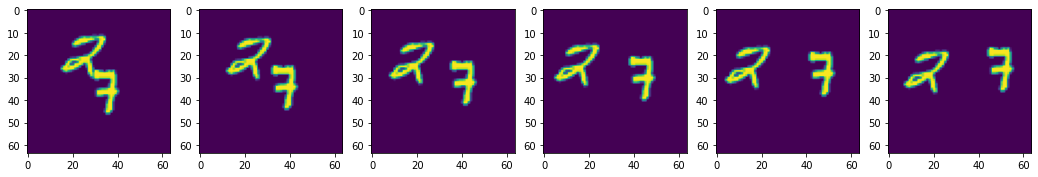

In [47]:
sample = dataset[0]

plt.figure(figsize=(18,6))
plt.subplot(1,6,1)
plt.imshow(sample[0][0])
plt.subplot(1,6,2)
plt.imshow(sample[0][1])
plt.subplot(1,6,3)
plt.imshow(sample[0][2])
plt.subplot(1,6,4)
plt.imshow(sample[0][3])
plt.subplot(1,6,5)
plt.imshow(sample[0][4])


plt.subplot(1,6,6)
plt.imshow(sample[1])

In [48]:
dataset = MovingMNIST(.8, True, 18)
dataloader = DataLoader(dataset, batch_size=2**5, num_workers=2, prefetch_factor=4, shuffle=True)

In [49]:
%%time
for epochs in range(3):
  for i in dataloader:
      X,target = i
      X = X.cuda()
      target = target.cuda()

CPU times: user 445 ms, sys: 937 ms, total: 1.38 s
Wall time: 1.78 s


In [68]:
from torch.utils.data import IterableDataset
import math

In [74]:
# from https://pytorch.org/docs/stable/data.html
torch.multiprocessing.set_sharing_strategy('file_system')
class MyIterableDataset(IterableDataset):
     def __init__(self, start, end):
         super(MyIterableDataset).__init__()
         assert end > start, "this example code only works with end >= start"
         self.start = start
         self.end = end

     def __iter__(self):
         worker_info = torch.utils.data.get_worker_info()
         if worker_info is None:  # single-process data loading, return the full iterator
             iter_start = self.start
             iter_end = self.end
         else:  # in a worker process
             # split workload
             per_worker = int(np.ceil((self.end - self.start) / float(worker_info.num_workers)))
             worker_id = worker_info.id
             iter_start = self.start + worker_id * per_worker
             iter_end = min(iter_start + per_worker, self.end)
         return iter(range(iter_start, iter_end))

# should give same set of data as range(3, 7), i.e., [3, 4, 5, 6].
%time ds = MyIterableDataset(start=0, end=1000)

# Single-process loading
print("\n Single Process")
%timeit list(torch.utils.data.DataLoader(ds, num_workers=0))


# Mult-process loading with two worker processes
# Worker 0 fetched [3, 4].  Worker 1 fetched [5, 6].
print("\n Multi Process")
%timeit list(torch.utils.data.DataLoader(ds, num_workers=2))

# With even more workers
print("\n Many Process")
%timeit _ = list(torch.utils.data.DataLoader(ds, num_workers=8))


CPU times: user 23 µs, sys: 1 µs, total: 24 µs
Wall time: 26.5 µs

 Single Process
3.75 ms ± 13.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

 Multi Process
425 ms ± 7.88 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

 Many Process
954 ms ± 13.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
